## General info

Two variables set: `filepath` in the third code cell, and `MODEL_SAVE_PATH` way down near the bottom. Configure them as you want.
- `filepath` is the CSV file of Neurosity Crown data
- `MODEL_SAVE_PATH` is the path to save the `.pth.tar` model (we named ours `p300LTSM.pth.tar`, follow one standardized format).

### TODO
- Understand why the accuracy on the very last cell gives me $0, 33.33,$ and $66.67\%$. (Did give Aaroosh $100\%$!)  
- Catch all `FileNotFoundError` errors. For `MODEL_SAVE_PATH` if file not found, assume it to be `./p300LTSM-{randint}.pth.tar`.  
-Rishabh

In [2]:
import mne 
from mne import create_info
from mne.io import RawArray

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, WeightedRandomSampler

In [3]:
mne.set_config('MNE_BROWSE_RAW_SIZE','10,5')  

In [4]:
filepath = "/Users/rishabh/code/eeg/speakEEG/training_data/eeg_data_7_good.csv"
# filepath = "/Users/aarooshbalakrishnan/Downloads/markers_eeg_data.csv"

df = pd.read_csv(filepath)
df.head()

,1-31,CP3,C3,F5,PO3,PO4,F6,C4,CP4,Marker
0,28.0,-15861.175781,-417.217621,-1631.855957,-17111.152344,-460.200012,-2150.326904,-644.735962,-27764.886719,0
1,29.0,-15885.181641,-6636.924805,-6022.900391,-17087.281250,-1033.656250,-6210.789062,-6266.914551,-27816.183594,0
2,30.0,-15818.126953,-4895.165527,-4476.271484,-17052.748047,-54.717064,-4564.248047,-4586.376465,-27716.406250,0
3,31.0,-15783.928711,1855.216919,401.392578,-17072.931641,776.231262,-119.760635,1436.054688,-27642.443359,0
4,0.0,-15845.417969,1289.203735,-313.483185,-17108.873047,-85.361305,-934.548706,879.228088,-27722.441406,0


In [5]:
df = df.drop(["1-31"], axis=1)
df.head()
df.columns = ["CP3", "C3", "F5", "PO3", "PO4", "F6", "C4", "CP4", "Marker"]

In [6]:
print(df['Marker'].unique())

[0 2 1]


Creating RawArray with float64 data, n_channels=9, n_times=36065
    Range : 0 ... 36064 =      0.000 ...   140.875 secs
Ready.
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/var/folders/jm/04n993nd2bsdf3z1z9k0621c0000gp/T/ipykernel_50137/1895213292.py:16: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


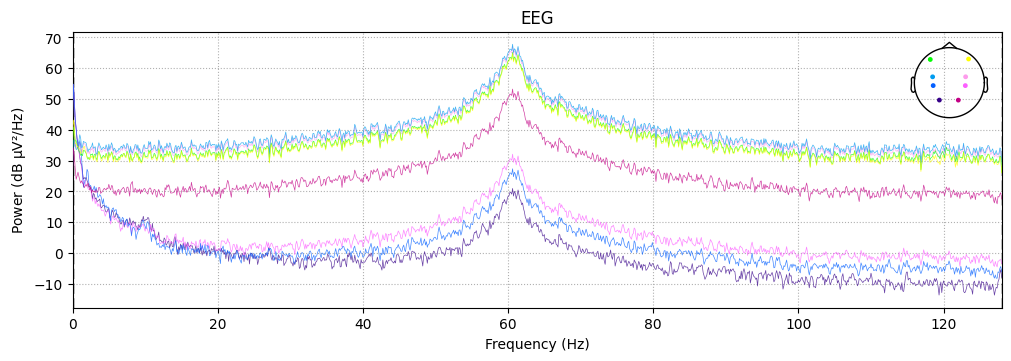

In [7]:
def df_to_raw(df):
    sfreq = 256  #our Neurosity headset sampling rate
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T 
    df[:-1] *= 1e-6  #convert from uVolts to Volts 

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #plotting power spectral density
    raw.compute_psd().plot()

    return raw
raw = df_to_raw(df)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

/var/folders/jm/04n993nd2bsdf3z1z9k0621c0000gp/T/ipykernel_50137/4134320637.py:4: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


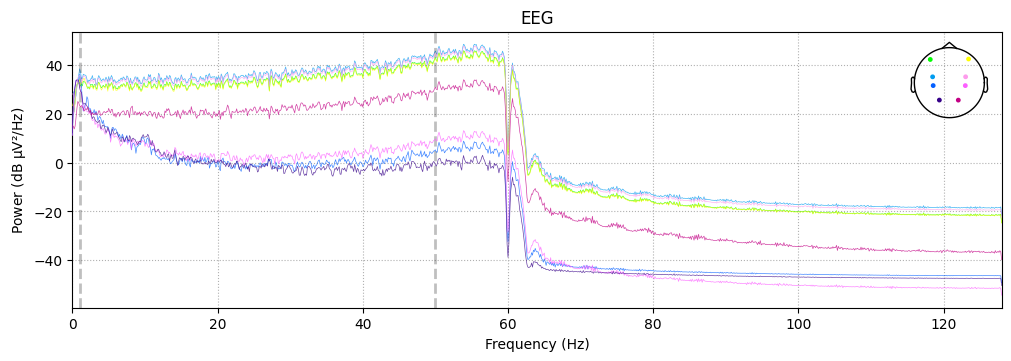

In [8]:
#wont be needed
raw.filter(1, 50)
raw.notch_filter(60)
raw.compute_psd().plot()

In [9]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [10]:
event_id = {'Non-Target': 1, 'Target' : 2} #changed nontarget from 1 to 0
tmin = -0.1 # tmin and tmax are changeable so we can always do that
tmax = 0.6 
eeg_channels = mne.pick_types(raw.info, eeg=True)
picks= eeg_channels
epochs = getEpochs(raw, event_id, tmin, tmax, picks)

141 events found on stim channel Marker
Event IDs: [1 2]
sample drop %:  0.0


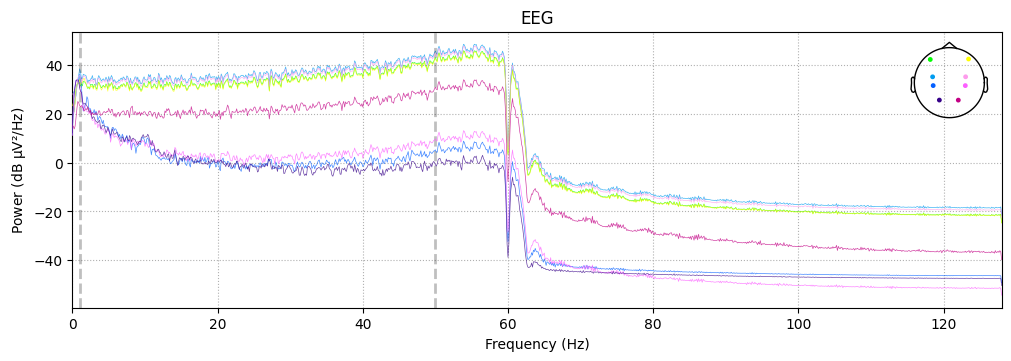

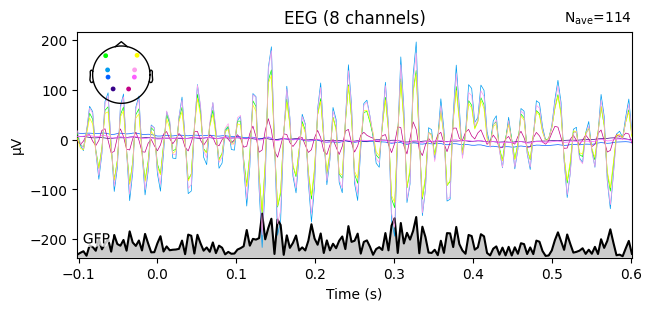

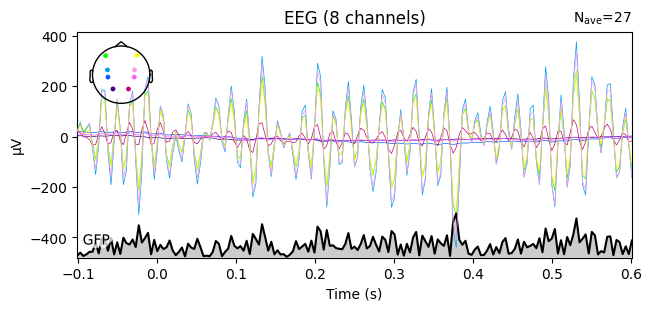

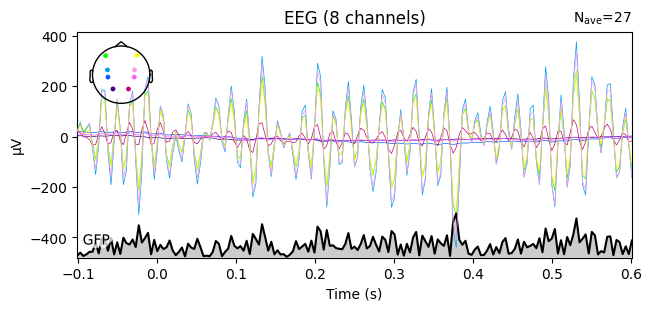

In [11]:
#ERP plots
evoked_non = epochs['Non-Target'].average() # ! 10/9/24 don't take avg
evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s')
evoked_target = epochs['Target'].average() # !
evoked_target.plot(spatial_colors=True, gfp=True, time_unit='s')

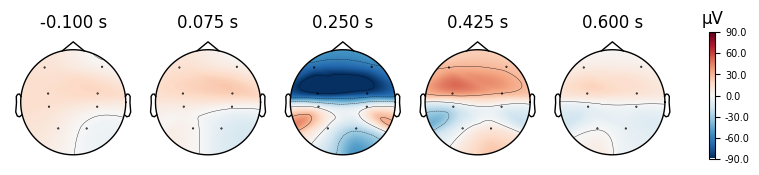

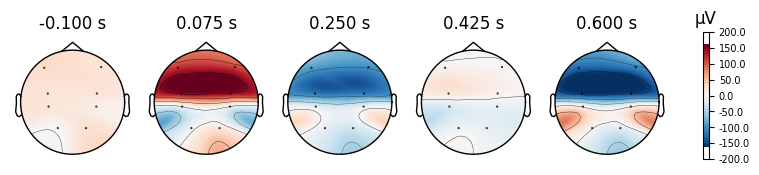

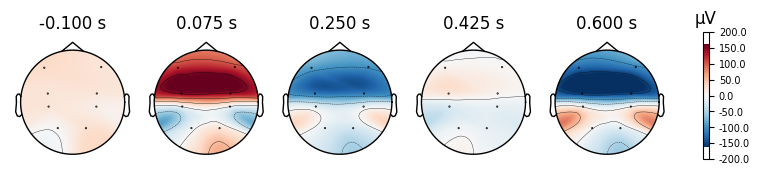

In [12]:
#topogrophies
times = np.linspace(-0.1, 0.6, 5)
evoked_non.plot_topomap(ch_type='eeg', times=times, colorbar=True)
evoked_target.plot_topomap(ch_type='eeg', times=times, colorbar=True)

No projector specified for this dataset. Please consider the method self.add_proj.


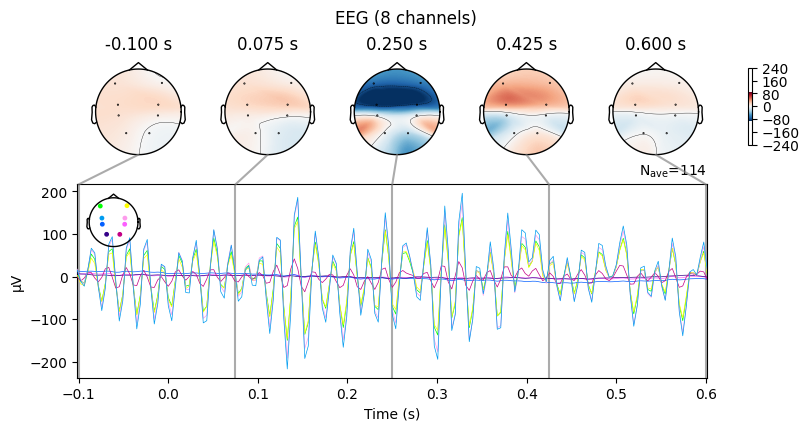

No projector specified for this dataset. Please consider the method self.add_proj.


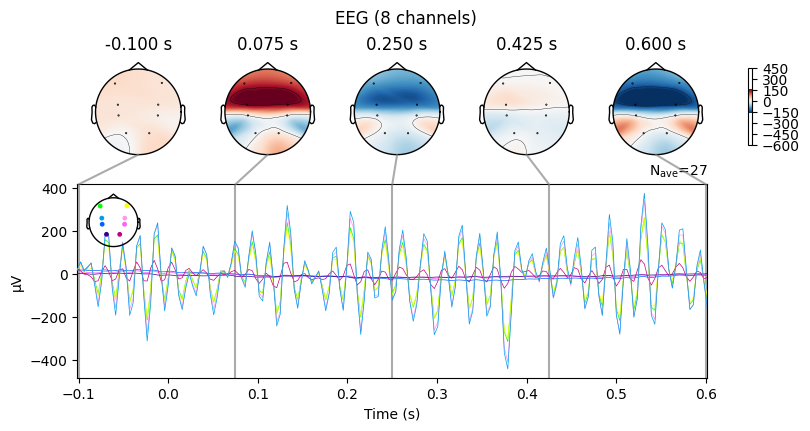

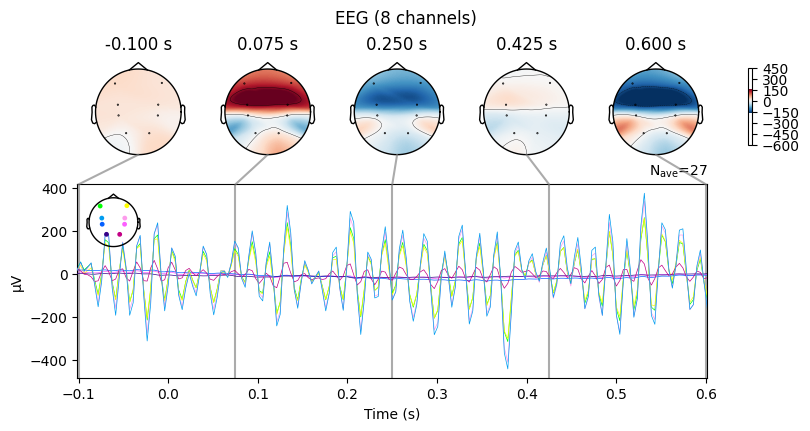

In [13]:
evoked_non.plot_joint(times=times)
evoked_target.plot_joint(times=times)

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


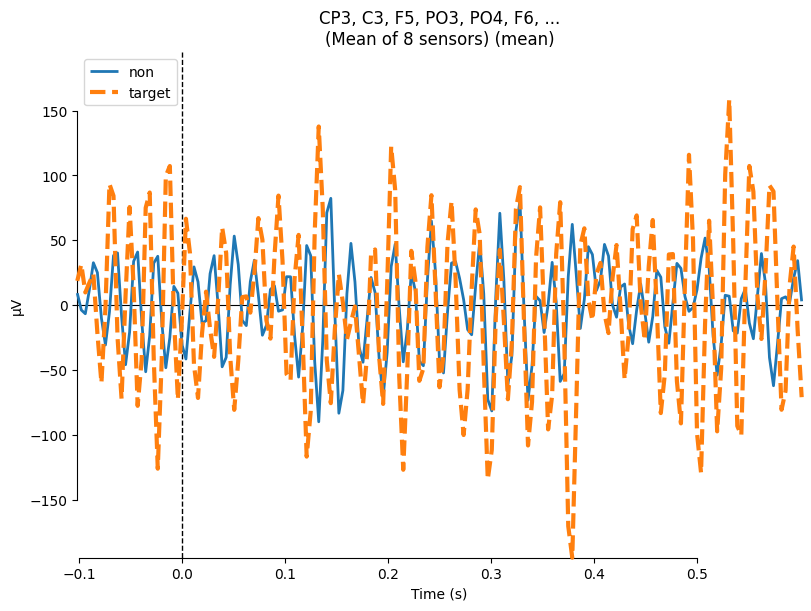

[<Figure size 800x600 with 1 Axes>]

In [14]:
#Comparison between target and nontarget
def custom_func(x):
    return x.max(axis=1)

total_evoked = {"non": evoked_non, "target": evoked_target}
# for combine in ('mean', 'median', 'gfp', custom_func):
mne.viz.plot_compare_evokeds(total_evoked, picks=[0,1,2,3,4,5,6,7], combine='mean',
                             colors=dict(non=0, target=1),
                             linestyles=dict(non='solid', target='dashed'),
                             styles=dict(non=dict(linewidth=2),target=dict(linewidth=3))) 

In [15]:
X = epochs.get_data()
y = epochs.events[:, -1]

print(X.shape)
print(y.shape)
print(type(X))

(141, 8, 181)
(141,)
<class 'numpy.ndarray'>


/var/folders/jm/04n993nd2bsdf3z1z9k0621c0000gp/T/ipykernel_32779/3820293213.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()


In [16]:
X[0].shape


(8, 181)

In [17]:
y[0]

2

In [18]:
train_size = 26 #.7 times total amount
val_size = 7 #.2 times total
test_size = 3 #.1 times total
#change above values

X_train   = X[:train_size]
X_val     = X[train_size:val_size+train_size]
X_test    = X[-test_size:]

y_train   = y[:train_size]
y_val     = y[train_size:val_size+train_size]
y_test    = y[-test_size:]

In [19]:
X_train = np.transpose(X_train, (0, 2, 1))
X_val   = np.transpose(X_val, (0, 2, 1))
X_test  = np.transpose(X_test, (0, 2, 1))

In [20]:
X_train.shape, X_val.shape, X_test.shape

((26, 181, 8), (7, 181, 8), (3, 181, 8))

In [21]:
from sklearn.preprocessing import MinMaxScaler

#scaling to make model train
scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i]) 

for i in range(X_val.shape[2]):
    X_val[:, :, i]   = scalers[i].transform(X_val[:, :, i])     
    
for i in range(X_test.shape[2]):
    X_test[:, :, i]  = scalers[i].transform(X_test[:, :, i]) 

In [22]:
print(X_train.mean(), X_val.mean(), X_test.mean())
print(X_train.min(), X_val.min(), X_test.min())
print(X_train.max(), X_val.max(), X_test.max())

0.0260364984838197 0.01139657902943264 0.02456206249186632
-1.0 -3.9127424663200334 -3.012657283159764
1.0000000000000004 4.35470362794846 2.828674287400501


In [23]:
X_train = torch.FloatTensor(X_train)
X_val   = torch.FloatTensor(X_val)
X_test  = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train) - 1 #minus 1 so it becomes 0 or 1
y_val   = torch.LongTensor(y_val)   - 1 #minus 1 so it becomes 0 or 1
y_test  = torch.LongTensor(y_test)  - 1 #minus 1 so it becomes 0 or 1

In [24]:
labels_unique, counts = np.unique(y, return_counts=True)
labels_unique, counts

(array([1, 2]), array([114,  27]))

In [25]:
class_weights = [sum(counts) / c for c in counts]
class_weights

[1.236842105263158, 5.222222222222222]

In [26]:
sample_weights_train = [class_weights[i] for i in y_train]
sample_weights_val   = [class_weights[i] for i in y_val  ]
sample_weights_test  = [class_weights[i] for i in y_test ]

sample_weights_train[:10]

[5.222222222222222,
 5.222222222222222,
 1.236842105263158,
 1.236842105263158,
 1.236842105263158,
 1.236842105263158,
 1.236842105263158,
 1.236842105263158,
 1.236842105263158,
 1.236842105263158]

In [27]:
train_sampler = WeightedRandomSampler(sample_weights_train, len(y_train), replacement=True)
val_sampler   = WeightedRandomSampler(sample_weights_val,   len(y_val),   replacement=True)
test_sampler  = WeightedRandomSampler(sample_weights_test,  len(y_test),  replacement=True)

In [28]:
ds_train = TensorDataset(X_train, y_train)
ds_val   = TensorDataset(X_val, y_val)
ds_test  = TensorDataset(X_test, y_test)

In [29]:
BATCH_SIZE = 10 

#Train set loader
train_loader = torch.utils.data.DataLoader(dataset=ds_train, 
                                           batch_size=BATCH_SIZE, 
                                           sampler = train_sampler)
#Validation set loader
val_loader = torch.utils.data.DataLoader(dataset=ds_val, 
                                           batch_size=BATCH_SIZE, 
                                           sampler = val_sampler)

#Test set loader
test_loader = torch.utils.data.DataLoader(dataset=ds_test, 
                                          batch_size=BATCH_SIZE, 
                                          sampler = test_sampler)

In [30]:
torch.set_printoptions(sci_mode=False)
for X_train, y_train in train_loader:
    print(torch.mean(X_train, axis=[1,2]))
    print(y_train)
    break

tensor([ 0.0112,  0.0029,  0.0491,  0.0230,  0.0112, -0.0014,  0.0382,  0.0806,
         0.0806,  0.0427])
tensor([1, 0, 0, 0, 1, 0, 1, 1, 1, 0])


In [31]:
class eegLSTM(nn.Module):
    def __init__(self, input_size = 8, hidden_size=50, out_size=2):
        super().__init__()
        self.lstm   = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, out_size) #taking the last hidden state
        
    def forward(self, seq):
        #seq shape: (10, 88, 8)
        out, (_, _) = self.lstm(seq)
        #out shape: (N, L, Hout * D) ==> (10, 88, 50)
        out = out[:, -1, :] #(B, Hout)
        # out = torch.mean(out, axis=1)  #you can also try meaning the hidden states
        #out shape: (10, 50)
        out = self.linear(out)
        #out shape: (10, 2)
        return out
        

In [32]:
fake_eeg_data = torch.randn((10, 88, 8)) # (batch_size, length, features/channels)
lstm   = nn.LSTM(8, 50, batch_first=True)
out, _ = lstm(fake_eeg_data)
torch.Size([10, 88, 50])
out = out[:, -1, :]  # last hidden state
torch.Size([10, 50])
linear = nn.Linear(50, 2)
out = linear(out)


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = eegLSTM().to(device)

In [34]:
torch.manual_seed(999999)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [35]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

  1600
 10000
   200
   200
   100
     2
______
 12102


In [37]:
#
#! CHECK THIS OUT
MODEL_SAVE_PATH = '/Users/aarooshbalakrishnan/Desktop/EEGWORK/EEG_Projs/p300LTSM.pth.tar'
MODEL_SAVE_PATH = "/Users/rishabh/code/eeg/speakEEG/p300LTSM.pth.tar"

epochs = 100

best_valid_loss = float('inf')
model.train()

# print(f"Training {type(model).__name__}")

for i in range(epochs):
    train_total = 0
    train_correct = 0
    val_total   = 0  
    val_correct = 0
    train_acc   = 0
    val_acc     = 0
    
    for X_train, y_train in train_loader:
    
        start_time = time.time()
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        yhat_train = model(X_train)
        
        # train acc
        _, predicted = torch.max(yhat_train.data, 1)  # returns max value, indices
        train_total += y_train.size(0)  # keep track of total
        train_correct += (predicted == y_train).sum().item()  # .item() give the raw number
        train_acc = 100 * (train_correct / train_total)
        
        train_loss = criterion(yhat_train, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        end_time = time.time()

        #val accuracy
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            yhat_val  = model(X_val)
            val_loss     = criterion(yhat_val, y_val)
            _, predicted = torch.max(yhat_val.data, 1)  # returns max value, indices
            val_total += y_val.size(0)  # keep track of total
            val_correct += (predicted == y_val).sum().item()  # .item() give the raw number
            val_acc = 100 * (val_correct / val_total)

        # save the best model
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            # print("Model:{} saved.".format(type(model).__name__))
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            best_model_index = i

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {i:2.0f} | Train acc: {train_acc: 2.2f} | " +
          f"loss: {train_loss:2.2f} | Val acc: {val_acc: 2.2f} | " +
          f"loss: {val_loss:2.2f} | Time: {epoch_mins}m {epoch_secs}s")

Epoch:  0 | Train acc:  42.31 | loss: 0.71 | Val acc:  38.10 | loss: 0.68 | Time: 0m 0s
Epoch:  1 | Train acc:  46.15 | loss: 0.65 | Val acc:  85.71 | loss: 0.54 | Time: 0m 0s
Epoch:  2 | Train acc:  61.54 | loss: 0.61 | Val acc:  52.38 | loss: 0.74 | Time: 0m 0s
Epoch:  3 | Train acc:  73.08 | loss: 0.69 | Val acc:  76.19 | loss: 0.59 | Time: 0m 0s
Epoch:  4 | Train acc:  50.00 | loss: 0.73 | Val acc:  57.14 | loss: 0.64 | Time: 0m 0s
Epoch:  5 | Train acc:  73.08 | loss: 0.68 | Val acc:  76.19 | loss: 0.63 | Time: 0m 0s
Epoch:  6 | Train acc:  92.31 | loss: 0.46 | Val acc:  33.33 | loss: 0.85 | Time: 0m 0s
Epoch:  7 | Train acc:  61.54 | loss: 0.62 | Val acc:  14.29 | loss: 1.29 | Time: 0m 0s
Epoch:  8 | Train acc:  76.92 | loss: 0.62 | Val acc:  9.52 | loss: 1.58 | Time: 0m 0s
Epoch:  9 | Train acc:  80.77 | loss: 0.29 | Val acc:  28.57 | loss: 0.82 | Time: 0m 0s
Epoch: 10 | Train acc:  80.77 | loss: 0.13 | Val acc:  47.62 | loss: 0.70 | Time: 0m 0s
Epoch: 11 | Train acc:  69.23 | l

In [38]:
model = eegLSTM().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

model.eval()

with torch.no_grad():
    total   = 0
    correct = 0
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        predictions   = model(X_test)
        test_loss     = criterion(predictions, y_test)
        _, predicted = torch.max(predictions.data, 1)  # returns max value, indices
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()  # .item() give the raw number
        acc = 100 * (correct / total)
    
print(f"Accuracy: {acc:2.3f}")

Accuracy: 0.000
